# Truncated SVD on Amazon Dataset

In [1]:
#import libraries.....
import time
import sqlite3
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.plotly as py
import plotly.tools as tls
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import normalize

from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from nltk.stem.porter import PorterStemmer

from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import datetime
from sklearn.model_selection import StratifiedKFold
import sklearn.metrics
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.decomposition import TruncatedSVD
from sklearn.cluster import KMeans
import scipy as sp
from scipy import sparse
import tqdm
from prettytable import PrettyTable
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

C:\Users\Administrator\Anaconda3\lib\site-packages\gensim\utils.py:1209: UserWarning:

detected Windows; aliasing chunkize to chunkize_serial



In [2]:
# using the SQLite Table to read data.
# The below SQlite file consists of 60000 rows with Time based splitting and Summary column preprocessed[Feature Engineering].
con = sqlite3.connect('./final_tbs_cleansummary_text.sqlite')

final_tbs=pd.read_sql_query("""select * from Reviews limit 10000""",con) # The table was preprocessed with time based splitting.
con.close()

final_tbs.head(5)

,level_0,index,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,CleanedText,Cleaned_Summary
0,0,138706,150524,0006641040,ACITT7DI6IDDL,shari zychinski,0,0,positive,939340800,EVERY book is educational,this witty little book makes my son laugh at l...,witti littl book make son laugh loud recit car...,everi book educ
1,30,138683,150501,0006641040,AJ46FKXOVC7NR,Nicholas A Mesiano,2,2,positive,940809600,This whole series is great way to spend time w...,I can remember seeing the show when it aired o...,rememb see show air televis year ago child sis...,whole seri great way spend time child
2,424,417839,451856,B00004CXX9,AIUWLEQ1ADEG5,Elizabeth Medina,0,0,positive,944092800,Entertainingl Funny!,Beetlejuice is a well written movie ..... ever...,beetlejuic well written movi everyth excel act...,entertainingl funni
3,330,346055,374359,B00004CI84,A344SMIA5JECGM,Vincent P. Ross,1,2,positive,944438400,A modern day fairy tale,"A twist of rumplestiskin captured on film, sta...",twist rumplestiskin captur film star michael k...,modern day fairi tale
4,423,417838,451855,B00004CXX9,AJH6LUC1UT1ON,The Phantom of the Opera,0,0,positive,946857600,FANTASTIC!,Beetlejuice is an excellent and funny movie. K...,beetlejuic excel funni movi keaton hilari wack...,fantast


In [3]:
def partition(x):
    if x == "positive":
        return 1
    return 0

actualScore = final_tbs['Score']
positiveNegative = actualScore.map(partition) 
final_tbs['Score'] = positiveNegative

final_tbs.head(5)


,level_0,index,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,CleanedText,Cleaned_Summary
0,0,138706,150524,0006641040,ACITT7DI6IDDL,shari zychinski,0,0,1,939340800,EVERY book is educational,this witty little book makes my son laugh at l...,witti littl book make son laugh loud recit car...,everi book educ
1,30,138683,150501,0006641040,AJ46FKXOVC7NR,Nicholas A Mesiano,2,2,1,940809600,This whole series is great way to spend time w...,I can remember seeing the show when it aired o...,rememb see show air televis year ago child sis...,whole seri great way spend time child
2,424,417839,451856,B00004CXX9,AIUWLEQ1ADEG5,Elizabeth Medina,0,0,1,944092800,Entertainingl Funny!,Beetlejuice is a well written movie ..... ever...,beetlejuic well written movi everyth excel act...,entertainingl funni
3,330,346055,374359,B00004CI84,A344SMIA5JECGM,Vincent P. Ross,1,2,1,944438400,A modern day fairy tale,"A twist of rumplestiskin captured on film, sta...",twist rumplestiskin captur film star michael k...,modern day fairi tale
4,423,417838,451855,B00004CXX9,AJH6LUC1UT1ON,The Phantom of the Opera,0,0,1,946857600,FANTASTIC!,Beetlejuice is an excellent and funny movie. K...,beetlejuic excel funni movi keaton hilari wack...,fantast


In [4]:
#Since Summary column gives move details about what the text is, I joined both the features[Feature Engineering].
final_tbs['Summary_CleanedText'] = final_tbs[['Cleaned_Summary', 'CleanedText']].apply(lambda x: ' '.join(x), axis=1)

print(final_tbs['Summary_CleanedText'][0])

everi book educ witti littl book make son laugh loud recit car drive along alway sing refrain hes learn whale india droop love new word book introduc silli classic book will bet son still abl recit memori colleg


In [5]:
tf_idf_vect = TfidfVectorizer(min_df=5,max_features=2000)
final_tfidf = tf_idf_vect.fit_transform(final_tbs['Summary_CleanedText'].values)

print("the shape of out text TFIDF vectorizer ",final_tfidf.get_shape())

the shape of out text TFIDF vectorizer  (10000, 2000)


In [6]:
tfidf_features = tf_idf_vect.get_feature_names()
#print("some sample features(unique words in the corpus)",features)

### Co-occurance Matrix

In [7]:
# Analytics vidhya Example of Co-occurance metrix
# https://www.analyticsvidhya.com/blog/2017/06/word-embeddings-count-word2veec/

'''length = 6
window = 2
features = ['He','is','not','lazy.','intelligent.','smart.']
matrix = np.zeros([length,length]) # n is the count of all words
def cal_occ(sentence,m):
    sentence = sentence.split()  
    #print(sentence)
    for i,word in enumerate(sentence):
        row = features.index(word)
        if word in features:  
            for j in range(max(i-window,0),min(i+window+1,len(sentence))):
                col_j = sentence[j]
                col = features.index(col_j)
                if row != col:
                    matrix[row,col]=m[row,col]+1
sentence = "He is not lazy. He is intelligent. He is smart."
cal_occ(sentence, matrix)

print(matrix)
[[0. 4. 2. 1. 2. 1.]
 [4. 0. 1. 2. 2. 1.]
 [2. 1. 0. 1. 0. 0.]
 [1. 2. 1. 0. 0. 0.]
 [2. 2. 0. 0. 0. 0.]
 [1. 1. 0. 0. 0. 0.]]'''

'length = 6\nwindow = 2\nfeatures = [\'He\',\'is\',\'not\',\'lazy.\',\'intelligent.\',\'smart.\']\nmatrix = np.zeros([length,length]) # n is the count of all words\ndef cal_occ(sentence,m):\n    sentence = sentence.split()  \n    #print(sentence)\n    for i,word in enumerate(sentence):\n        row = features.index(word)\n        if word in features:  \n            for j in range(max(i-window,0),min(i+window+1,len(sentence))):\n                col_j = sentence[j]\n                col = features.index(col_j)\n                if row != col:\n                    matrix[row,col]=m[row,col]+1\nsentence = "He is not lazy. He is intelligent. He is smart."\ncal_occ(sentence, matrix)\n\nprint(matrix)\n[[0. 4. 2. 1. 2. 1.]\n [4. 0. 1. 2. 2. 1.]\n [2. 1. 0. 1. 0. 0.]\n [1. 2. 1. 0. 0. 0.]\n [2. 2. 0. 0. 0. 0.]\n [1. 1. 0. 0. 0. 0.]]'

In [8]:
start=time.time()   

length = 2000
window = 5
matrix = np.zeros([length,length]) # n is the count of all words
def cal_occ(sentence,m):
    sentence = sentence.split()       
    for i,word in enumerate(sentence):
        if word in tfidf_features:  
            row = tfidf_features.index(word)
            for j in range(max(i-window,0),min(i+window+1,len(sentence))):
                col_j = sentence[j]
                if col_j in tfidf_features:
                    col = tfidf_features.index(col_j)
                    if row != col:
                        matrix[row,col]=m[row,col]+1
        else:
            continue
            
    
    
for sentence in final_tbs['Summary_CleanedText']:
    cal_occ(sentence, matrix)
    
end=time.time()-start
print(time.strftime("%H:%M:%S", time.gmtime(end)))

00:02:56


In [9]:
matrix = np.matrix(matrix)

In [10]:
type(matrix)

numpy.matrixlib.defmatrix.matrix

### Truncated SVD

In [11]:
tsvd = TruncatedSVD(algorithm='randomized',random_state=42)

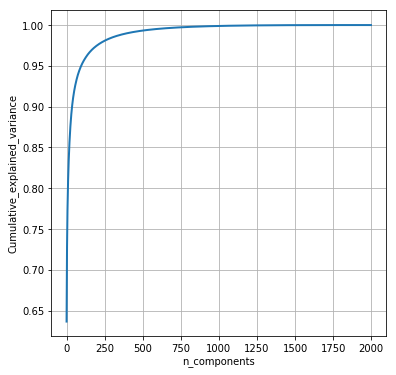

In [12]:
tsvd.n_components = 1999
tsvd_data = tsvd.fit_transform(matrix)

percentage_var_explained = tsvd.explained_variance_ / np.sum(tsvd.explained_variance_);

cum_var_explained = np.cumsum(percentage_var_explained)

# Plot 
plt.figure(1, figsize=(6, 6))

plt.clf()
plt.plot(cum_var_explained, linewidth=2)
plt.axis('tight')
plt.grid()
plt.xlabel('n_components')
plt.ylabel('Cumulative_explained_variance')
plt.show()


In [13]:
tsvd_opt = TruncatedSVD(n_components=500,algorithm='randomized',random_state=42)
tsvd_data_opt = tsvd_opt.fit_transform(matrix)

### KMeans

In [14]:
def kmeans(final_std):
    start=time.time()

    inertia = []
    clusters = [10,15,20,30]
    for k in clusters:
        kmeans = KMeans(n_clusters=k,random_state=42).fit(final_std)
        inertia.append(kmeans.inertia_)
    
    plt.plot(clusters, inertia)
    plt.xlabel('Clusters(K)')
    plt.ylabel('Sum of squared distances of samples')
    plt.show()

    end=time.time()-start
    print(time.strftime("%H:%M:%S", time.gmtime(end)))

In [15]:
'''count_vect = CountVectorizer(min_df=5) #in scikit-learn
final_bows = count_vect.fit_transform(final_tbs['Summary_CleanedText'])

Standard = StandardScaler(with_mean=False)
final_std_bows = Standard.fit_transform(final_bows)'''

"count_vect = CountVectorizer(min_df=5) #in scikit-learn\nfinal_bows = count_vect.fit_transform(final_tbs['Summary_CleanedText'])\n\nStandard = StandardScaler(with_mean=False)\nfinal_std_bows = Standard.fit_transform(final_bows)"

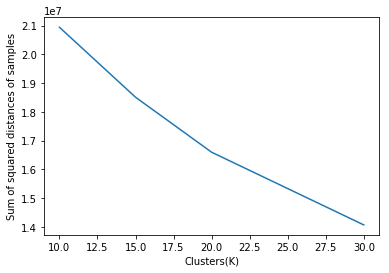

00:00:06


In [16]:
kmeans(tsvd_data_opt)

In [17]:
opt_k = KMeans(n_clusters=20,random_state=42).fit(tsvd_data_opt)

In [18]:
def plot_wordcloud(text):
    # Create and generate a word cloud image:
    wordcloud = WordCloud(width = 1500, height = 600, 
                background_color ='white',  
                min_font_size = 10).generate(text) 
  
    # plot the WordCloud image                        
    plt.figure(figsize = (8, 8), facecolor = None) 
    plt.imshow(wordcloud) 
    plt.axis("off") 
    plt.tight_layout(pad = 0) 
  
    plt.show()

Cluster 0


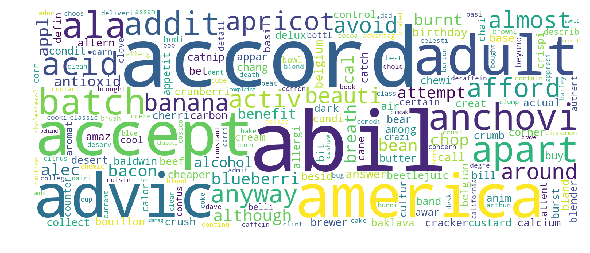

Cluster 1


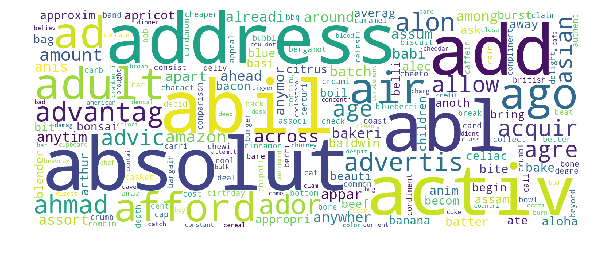

Cluster 2


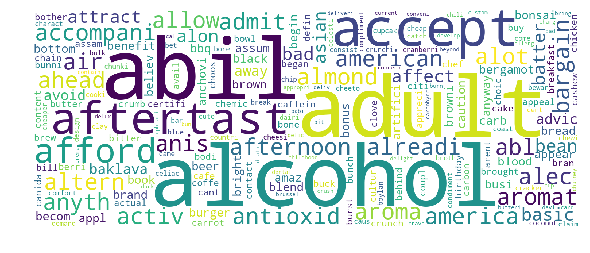

Cluster 3


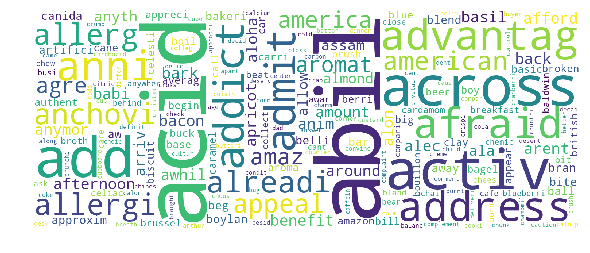

Cluster 4


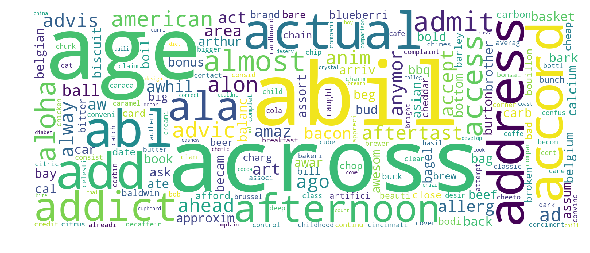

Cluster 5


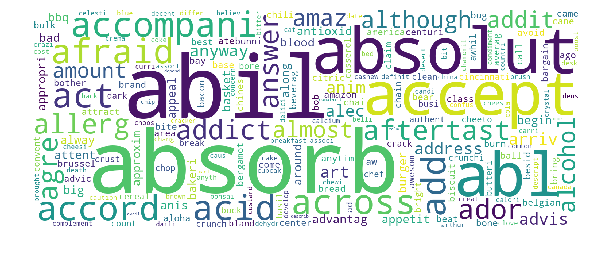

Cluster 6


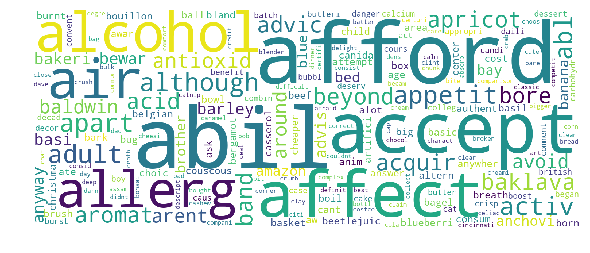

Cluster 7


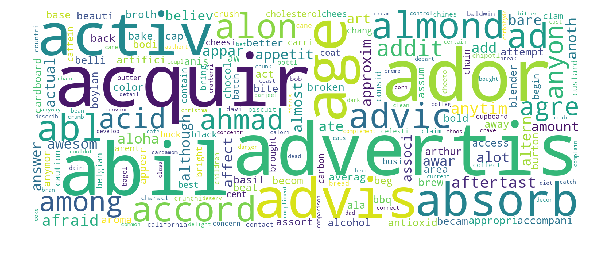

Cluster 8


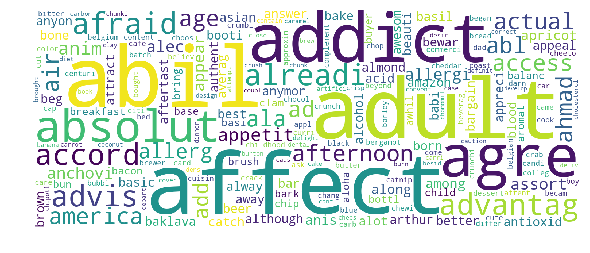

Cluster 9


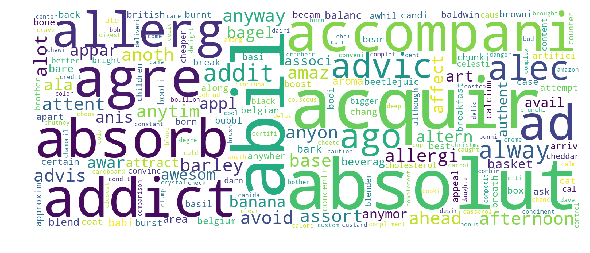

Cluster 10


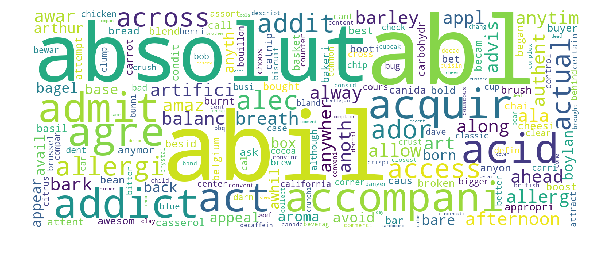

Cluster 11


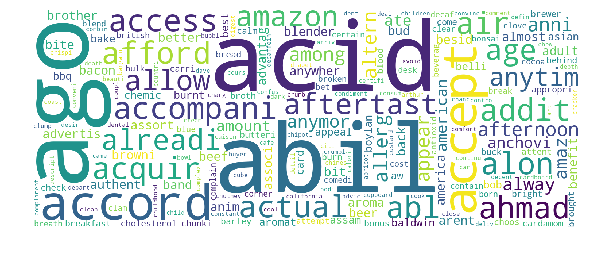

Cluster 12


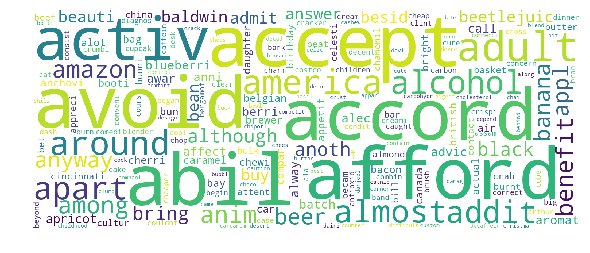

Cluster 13


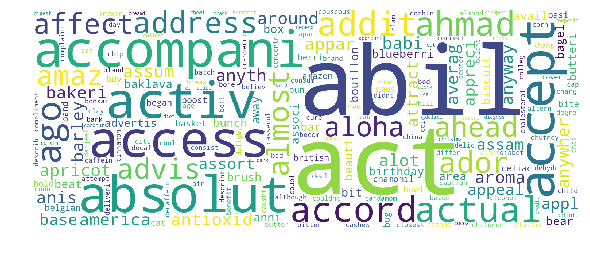

Cluster 14


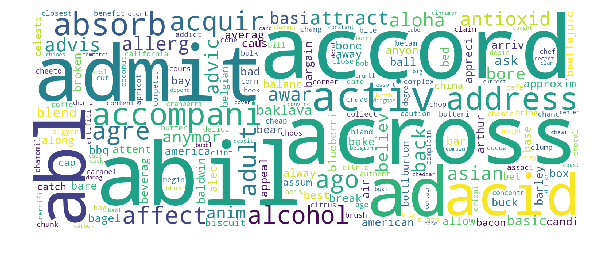

Cluster 15


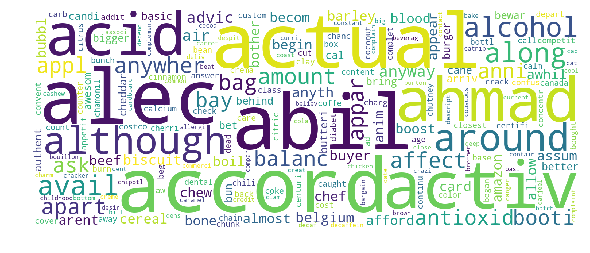

Cluster 16


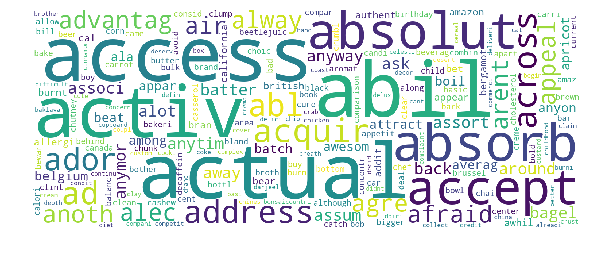

Cluster 17


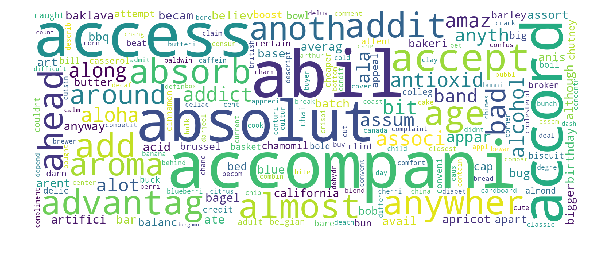

Cluster 18


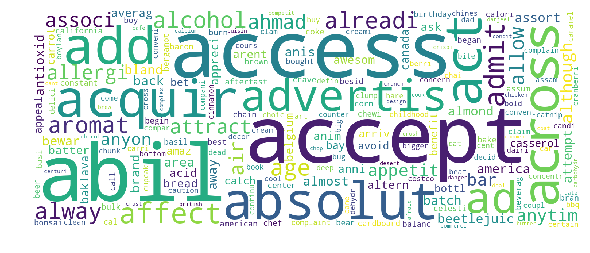

Cluster 19


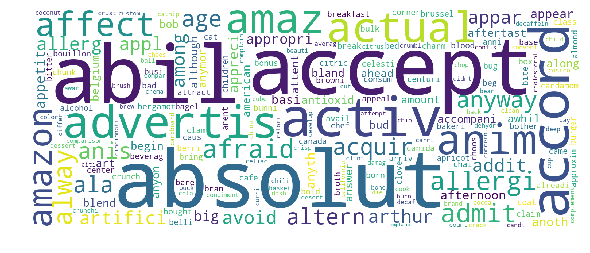

In [19]:
# cluster_centers_ -> Coordinates of Cluster centres

words = []
order_centroids = opt_k.cluster_centers_.argsort()[:, ::-1]
terms = tf_idf_vect.get_feature_names()
for i in range(20):
    text = ' '
    print("Cluster",i),
    for ind in order_centroids[i]:
        text = text + terms[ind] + ' '
    words.append(text)
    plot_wordcloud(text)

### Cosine Similarity

In [128]:
cs = cosine_similarity(tsvd_data_opt)

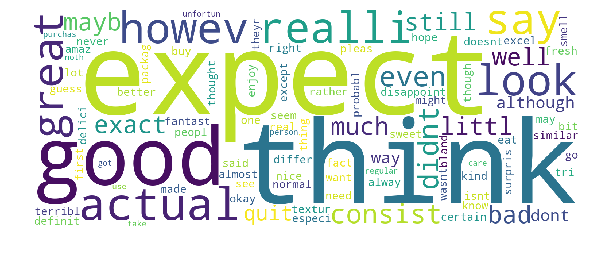

In [150]:
text = ' '

sample_word = "expect"

if sample_word in tfidf_features:  
        row = tfidf_features.index(sample_word)
        indeces = cs[row].argsort()[::-1][:100]
        
for i in indeces:
    text = text + tfidf_features[i] + ' '

plot_wordcloud(text)